# Лабораторная работа №1 по дисциплине Математические пакеты

### Выполнил: Хотяков Евгений, гр. 9383
### Вариант 18

## Задание 1: Построение огибающей

<p>Имеется сигнал x(i), i = 0,1, . . . ,N − 1 Хотим построить огибающую y(j), j = 0,1, . . . ,n− 1
Пусть $m = \begin{bmatrix} \frac{N}{n} \end{bmatrix}$ — число точек в интервале усреднения. 
Тогда $y(j) = \frac{1}{m}\sum_{k = mj}^{mj+m-1} \left | x(k) \right |$</p>

In [15]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt

In [23]:
# read audio samples
samplerate, input_data = wavfile.read("original.wav")
audio_time = input_data.size / samplerate
x1 = np.linspace(0, audio_time, input_data.size)

<ipython-input-23-b0f87bf9075e>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, input_data = wavfile.read("original.wav")


In [75]:
n = 700
N = input_data.size
m = N // n
y = []
x2 = np.linspace(0, audio_time, n)

for i in range(n):
    sum = 0
    for j in range(m*i, m*i+m):
        sum+=abs(input_data[j])
    y.append(sum / m)

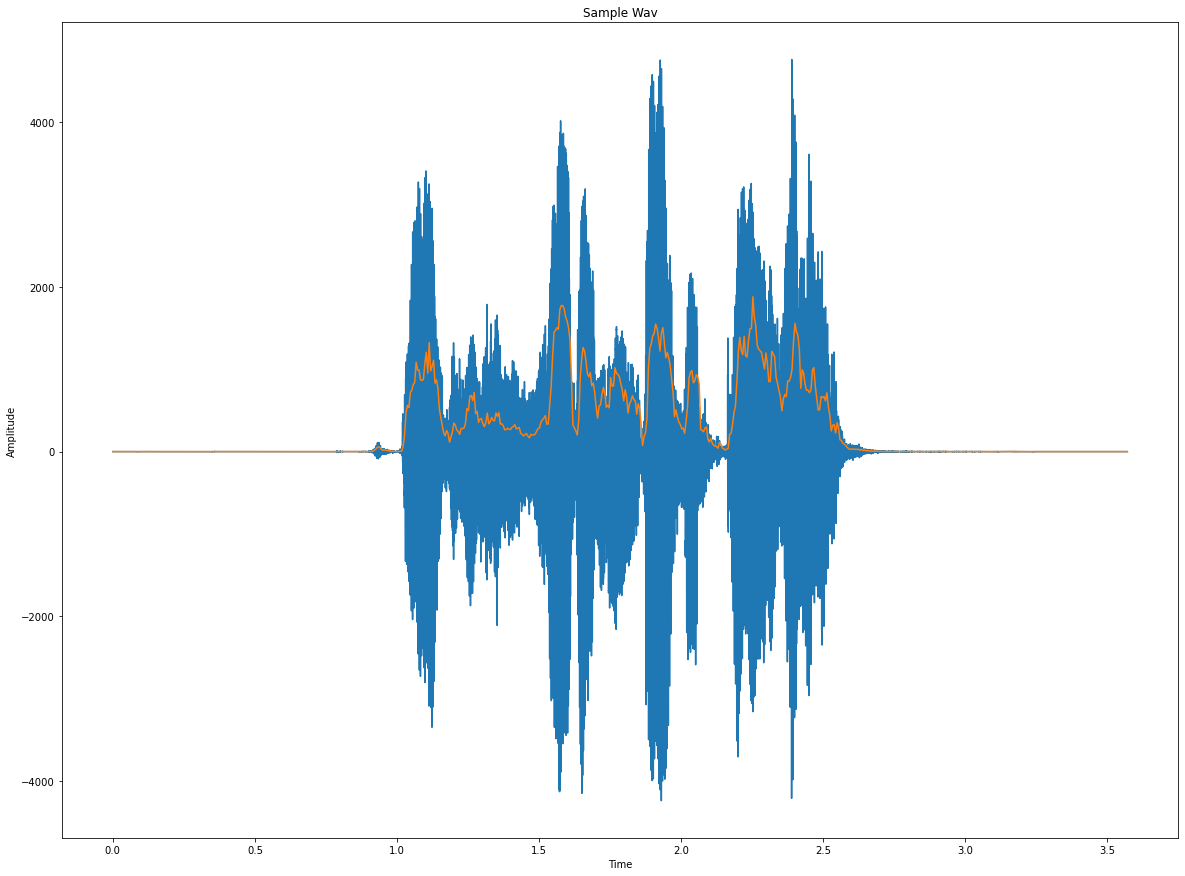

In [76]:
plt.rcParams["figure.figsize"]=20, 15
plt.plot(x1, input_data)
plt.plot(x2, y)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Original Wav")
plt.show()

## Задание 2: Фильтрация

<p>В качестве фильтра был выбран фильтр высоких частот(ФВЧ)</p>
<p>Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$. Порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}}{F_{d}}$.</p>

In [191]:
order = 2
Fs = max(input_data) * 1/2**0.5
Wn = 2 * Fs / samplerate
b, a = signal.butter(order, Wn, 'highpass') #фильтр выскоих частот
filtedData = signal.filtfilt(b, a, input_data)
wavfile.write('filtered.wav',samplerate,np.asarray(filtedData, dtype=np.int16))

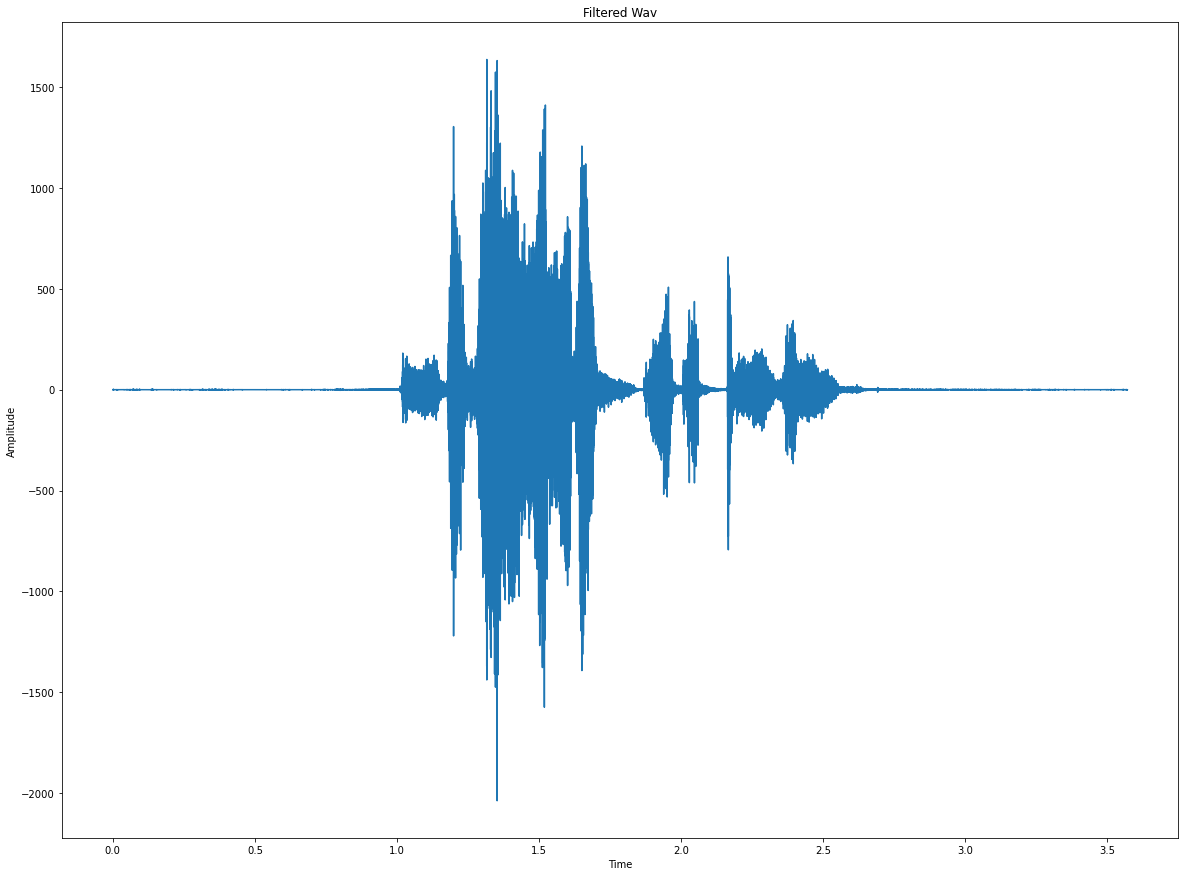

In [192]:
plt.rcParams["figure.figsize"]=20, 15    
plt.plot(x1, filtedData)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Filtered Wav")
plt.show()

## Задание 3: Амплитудный детектор(сигнал/шум)

<p>Определяем среднее сигнала по амплитуде(без учета знака):
$mid = \frac{1}{N}\sum{k=0}{N-1}|x(k)|$</p>
<p>Определяем порог детектора - $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментально. Задаем величину "провала"(в отсчетах) - $k$. Обозначим $y(i)$ - сигнал после детектирования. </p>
<ol>
<li>Событие "начало сигнала". Если $x(i)$ в течение $k$ отсчетов превышает порог, $y(i) = x(i)$.</li> 
<li>Событие "окончание сигнала". Если $x(i)$ в течение $k$ отсчетов меньше порога, $y(i) = 0$.</li> 
</ol>

In [175]:
sum = 0
count = 0
for i in range(N): 
    if(input_data[i] > 0): #не учитываю начальные нулевые сигналы(иначе среднее занчение получается слишком маленьким)
        count+=1
        sum+=abs(input_data[i])
mid = sum / count
Th = 0.7 * mid
AmplDetectorData = []
k = 100
for i in range (0, N, k):
    count = 0
    minK = min(k, N - i)
    for j in range(minK):
        if(abs(input_data[i+j]) < Th):
            count-=1
        elif(abs(input_data[i+j]) >= Th):
            count+=1
    if(count == -1 * minK):
        for j in range(minK):
            AmplDetectorData.append(0)
    else:
        for j in range(minK):
            AmplDetectorData.append(input_data[i+j])
            
wavfile.write('amplDetector.wav',samplerate,np.asarray(AmplDetectorData, dtype=np.int16))             

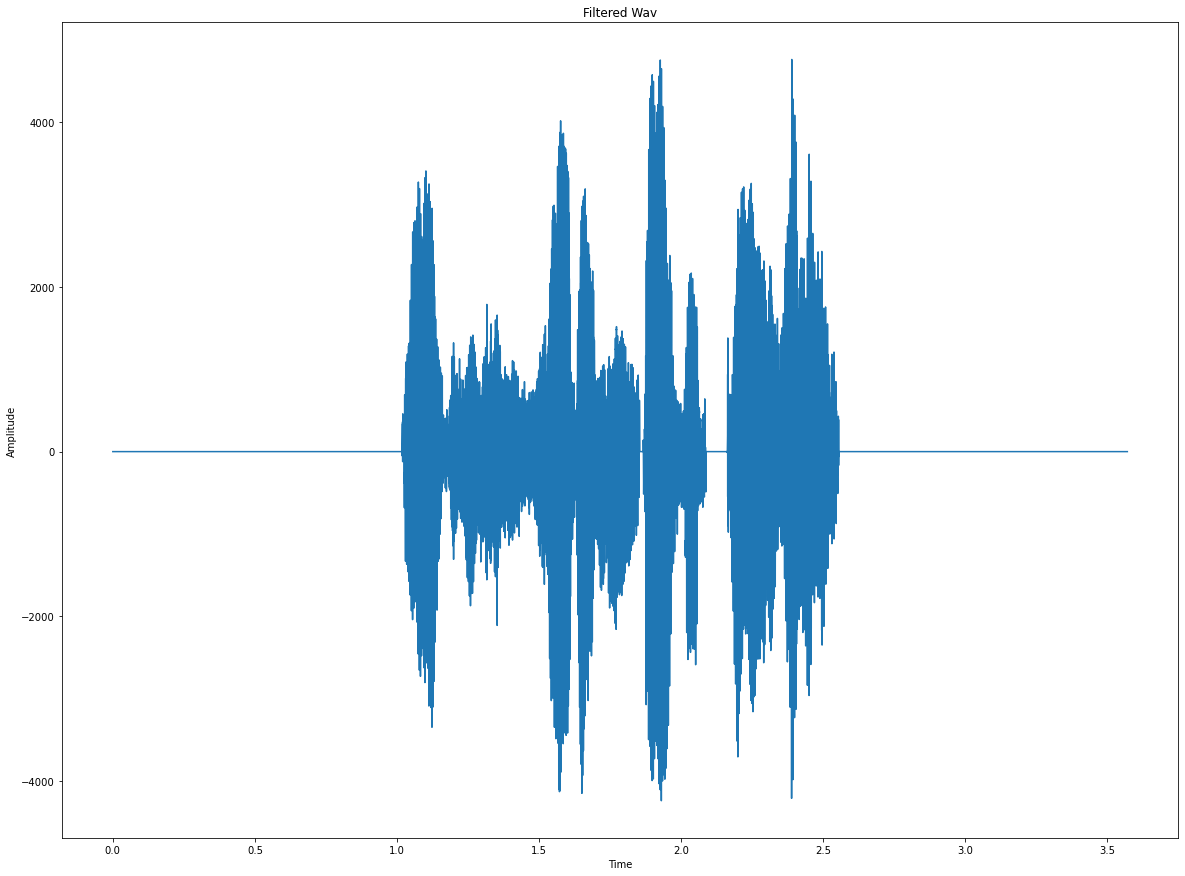

In [176]:
plt.rcParams["figure.figsize"]=20, 15        
plt.plot(x1, AmplDetectorData)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Filtered Wav")
plt.show()

## Задание 4: Эхо(простейший ревербератор)
Ревербератор состоит из 8 линий задержки. Каждая линия задержки имеет свой весовой коэффициент. Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка. Соотношение между начальным и обработанным сигналом задается коэффициентом применимости $\gamma$.

Значения задержек: $D_i = D_1 * 2^{(1-i)/N_L}, i = 2,...,8$.

Весовые коэффициенты при линиях задержек: $\alpha_i$ = 1 - $\alpha_{i-1}$ * 0.5, i = 1,...,8

In [183]:
Nl = 8
alphas = [0.8]
D = [int(samplerate * 100 / 335)]
Del = [D[0]]
gamma = 0.9
for i in range(1, Nl):
    alphas.append(alphas[i-1] * 0.5)
    D.append(int(D[0] * 2 ** ((-i)/Nl)))
    Del.append(Del[i-1] + D[i])
summaryDelay = Del[-1]

echoDat = np.zeros(summaryDelay + N)
echos = []

for i in range(Nl):
    echos.append(input_data * alphas[i])
    for j in range(N):
        echoDat[Del[i] + j] += echos[i][j]

Fs = max(echoDat) * 1/2**0.5
Wn = 2 * Fs / samplerate        

b, a = signal.butter(1, Wn, 'lowpass')
filtedEcho = signal.filtfilt(b, a, echoDat)

filtedEcho = filtedEcho * gamma

for i in range(N):
    filtedEcho[i] += input_data[i]


audio_time = echoDat.size / samplerate
x3 = np.linspace(0, audio_time, filtedEcho.size)
wavfile.write('echo.wav',samplerate,np.asarray(filtedEcho, dtype=np.int16))

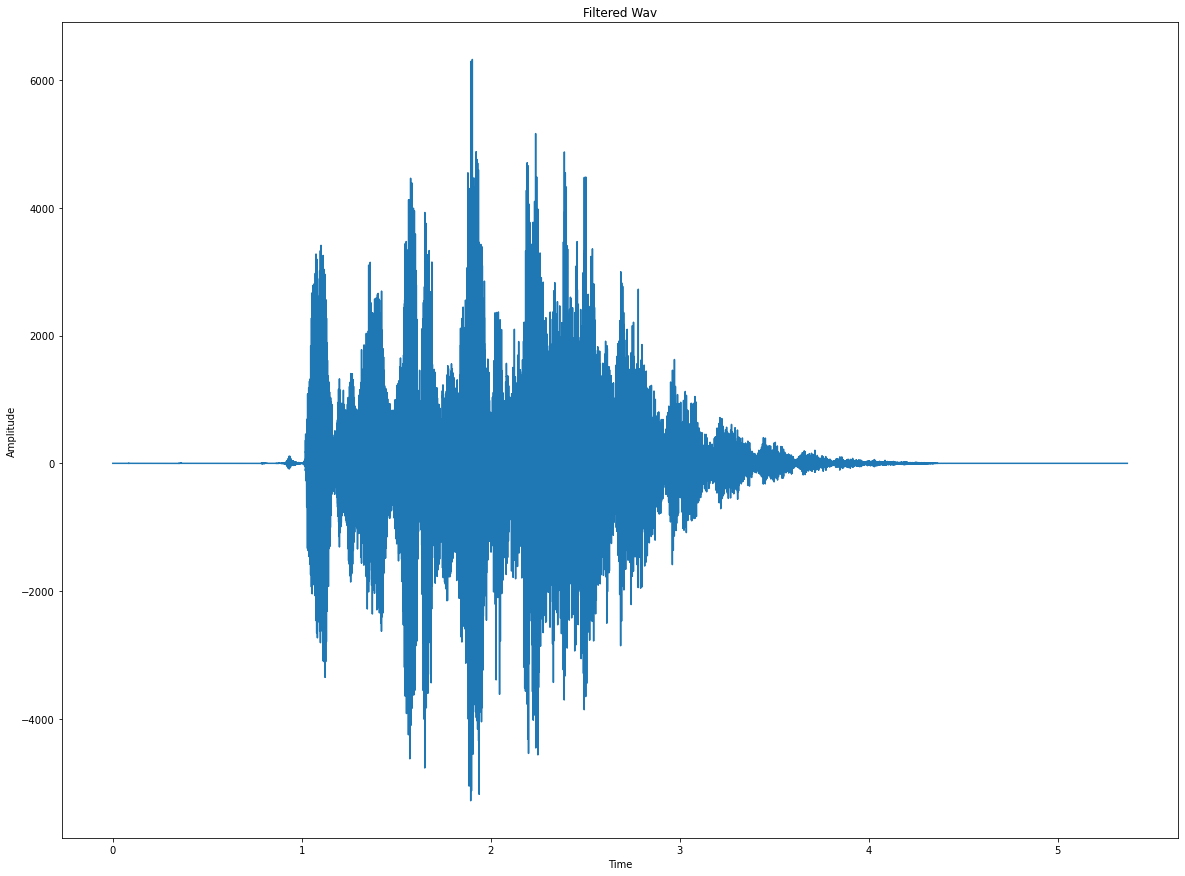

In [160]:
plt.rcParams["figure.figsize"]=20, 15    
plt.plot(x3, filtedEcho)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Echo Wav")
plt.show()

## Задание 5: Классический Distortion

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i)$, $i = 0, 1, ..., N-1$. Пользователь задает порог - $Th$ и максимальное значение сигнала $Max > Th$. Тогда $Y(i) = \left\{\begin{matrix}
 & x(i), |x(i)| < Th\\ 
 & Max * sign(x(i)), |x(i)| > Th
\end{matrix}\right.$

In [189]:
Th = mid * 1.5
maxSig = Th * 5
distortionData = []
for i in input_data:
    if(abs(i) <= Th):
        distortionData.append(i)
    else:
        distortionData.append(maxSig * np.sign(i))
wavfile.write('distortion.wav',samplerate,np.asarray(distortionData, dtype=np.int16))

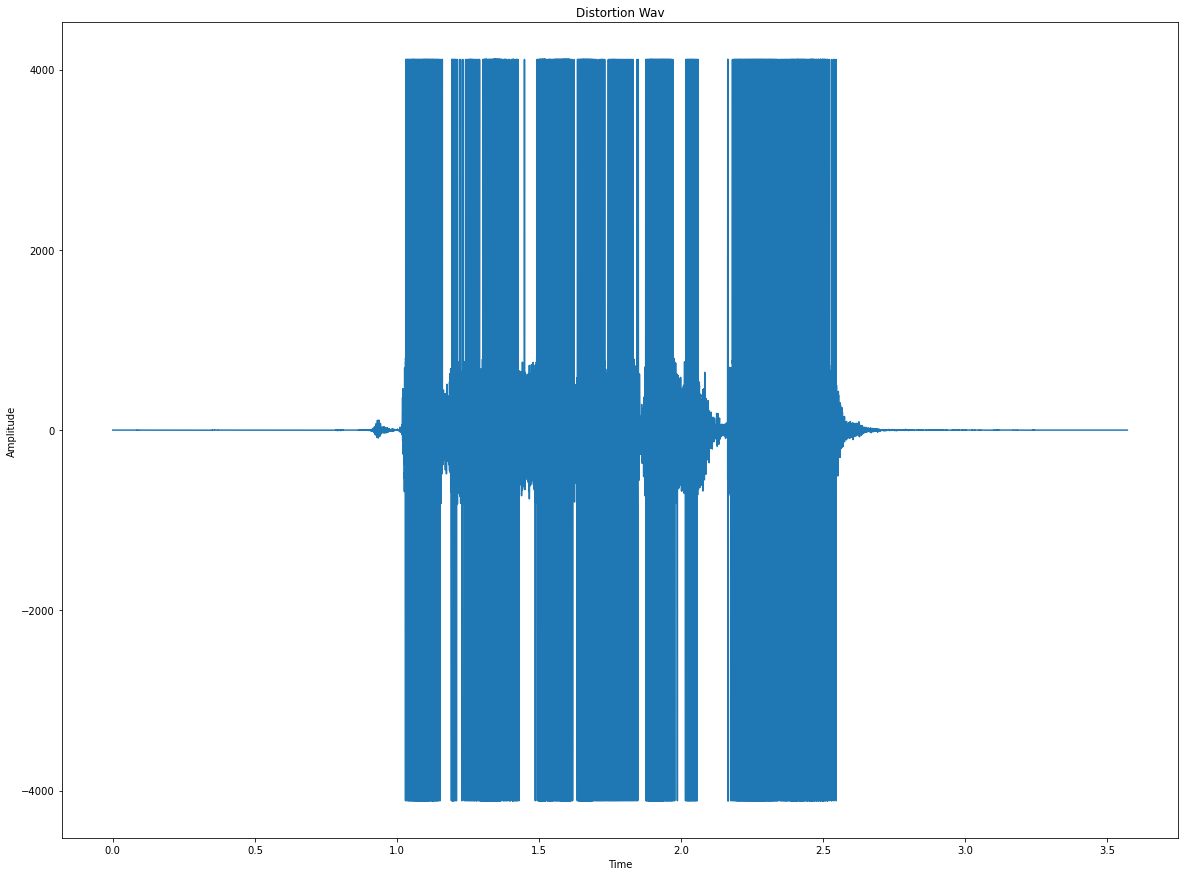

In [190]:
plt.rcParams["figure.figsize"]=20, 15    
plt.plot(x1, distortionData)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Distortion Wav")
plt.show()